## Import

In [1]:
import os
from fastai.vision.all import *
from pathlib import Path
import numpy as np
# to avoid warning of PyTorch
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
# gradCAM
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt

## Download dataset from Kaggle

In [ ]:
! {sys.executable} -m pip install kaggle --upgrade

To be able to download data from Kaggle you have to provide an API token, which you can find on your Kaggle account. In case of doubt find more information in the following link:

https://github.com/Kaggle/kaggle-api#:~:text=To%20use%20the%20Kaggle%20API,file%20containing%20your%20API%20credentials

In [2]:
path = Path('./')/'architecture'
path.mkdir(parents=True, exist_ok=True)
path

Path('architecture')

In [ ]:
# ! kaggle datasets download -d wwymak/architecture-dataset # ORIGINAL DATASET

In [ ]:
# bigger dataset
# ! kaggle datasets download -d dumitrux/architectural-styles-dataset # EXTENDED DATASET

In [ ]:
# international dataset (dataset we created ourselves)
! kaggle datasets download -d jungseolin/international-architectural-styles-combined

In [ ]:
# ! wsl unzip -q -n architecture-dataset.zip -d {path}
# ! wsl unzip -q -n architectural-styles-dataset -d {path}
! wsl unzip -q -n international-architectural-styles-combined.zip -d {path}

## Looking at the data

We are going to use the International Architectural Styles Combined dataset by Seolin Jung, which features 45 architecture styles. Our model will need to learn to differentiate between these 45 distinct categories. The best accuracy we could get in 2024/December/01 was nearly 76% accuracy.

In [3]:
os.listdir(path/'international-architectural-styles-combined')

['Achaemenid architecture',
 'Amazigh architecture',
 'American craftsman style',
 'American Foursquare architecture',
 'Ancient Egyptian architecture',
 'Architecture of Edo Period',
 'Architecture of the Joseon Dynasty',
 'Architecture of the Qing Dynasty',
 'Art Deco architecture',
 'Art Nouveau architecture',
 'Balinese architecture',
 'Baroque architecture',
 'Bauhaus architecture',
 'Beaux-Arts architecture',
 'Brutalist architecture',
 'Buddhist architecture',
 'Byzantine architecture',
 'Chicago school architecture',
 'Colonial architecture',
 'Deconstructivism',
 'Dravidian architecture',
 'Edwardian architecture',
 'export.pkl',
 'Georgian architecture',
 'Gothic architecture',
 'Greek Revival architecture',
 'Hausa architecture',
 'International style',
 'Jain architecture',
 'Khmer architecture',
 'Maya architecture',
 'Minangkabau architecture',
 'models',
 'Moorish architecture',
 'Mughal architecture',
 'Novelty architecture',
 'Ottoman architecture',
 'Palladian archite

The first thing we do when we approach a problem is to take a look at the data. We always need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

In this particular dataset, labels are stored in the folder name which containt images of each class. We will need to extract them to be able to classify the images into the correct categories. The fastai library has a function made for this, `ImageDataBunch.from_folder`.

In [4]:
# to not get different results everytime and to be sure that the improvement
# has not been only been chance
np.random.seed(42)

In [5]:
# transform the data to achive data augmentation, we will see more about this later
tfms = aug_transforms(do_flip=True, flip_vert=False, max_rotate=10, max_zoom=1.1,
                      max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

In [6]:
data = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2,
        item_tfms=Resize(224, method='squish'), # Ensure images are resized to the correct size before augmentation
        batch_tfms=[*tfms, Normalize.from_stats(*imagenet_stats)], # Applying augmentation and normalization as batch transforms
        size=224, num_workers=4, padding_mode='reflection', bs=64)

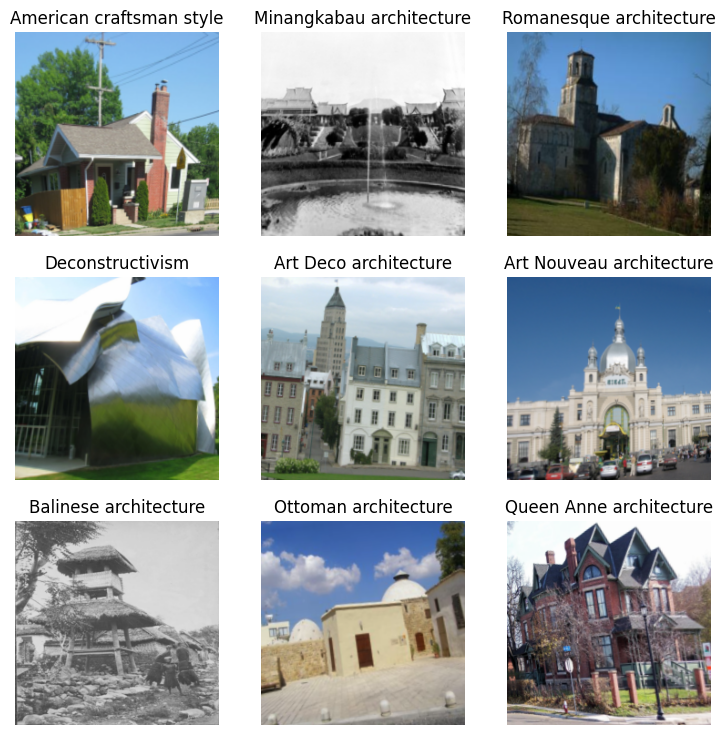

In [7]:
data.show_batch(nrows=3, figsize=(9, 9))

In [8]:
data.vocab, data.c, len(data.train_ds), len(data.valid_ds)

(['Achaemenid architecture', 'Amazigh architecture', 'American Foursquare architecture', 'American craftsman style', 'Ancient Egyptian architecture', 'Architecture of Edo Period', 'Architecture of the Joseon Dynasty', 'Architecture of the Qing Dynasty', 'Art Deco architecture', 'Art Nouveau architecture', 'Balinese architecture', 'Baroque architecture', 'Bauhaus architecture', 'Beaux-Arts architecture', 'Brutalist architecture', 'Buddhist architecture', 'Byzantine architecture', 'Chicago school architecture', 'Colonial architecture', 'Deconstructivism', 'Dravidian architecture', 'Edwardian architecture', 'Georgian architecture', 'Gothic architecture', 'Greek Revival architecture', 'Hausa architecture', 'International style', 'Jain architecture', 'Khmer architecture', 'Maya architecture', 'Minangkabau architecture', 'Moorish architecture', 'Mughal architecture', 'Novelty architecture', 'Ottoman architecture', 'Palladian architecture', 'Postmodern architecture', 'Pueblo architecture', 'Q

#### Data augmentation

The `get_transforms` fucntion helped us to get more images to train, in this case we have 9588 images instead of 4979 from the original dataset.

This is achived making some changes to the images and treat them like news images.

Flipping (just horizontal), zooming, light, rotate, etc.

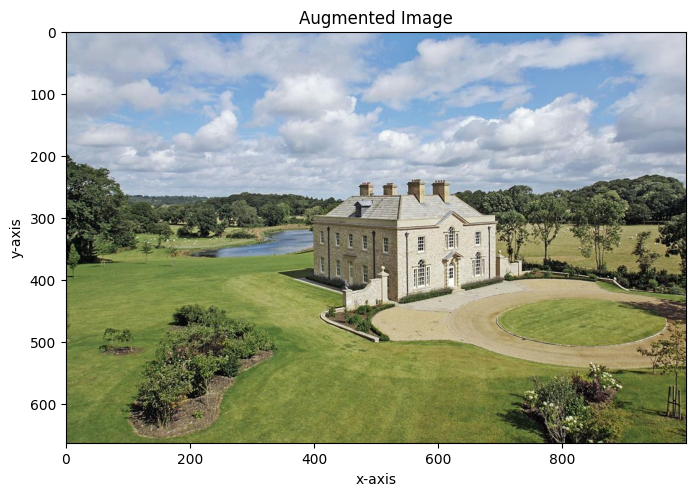

In [9]:
import matplotlib.pyplot as plt

def plot_function(tx=None, ty=None, title=None, min=-2, max=2, figsize=(6, 4)):
    """
    Plots a function.

    This function has been modified to handle the _plot function correctly.

    Args:
        tx: Label for the x-axis.
        ty: Label for the y-axis.
        title: Title of the plot.
        min: Minimum value for the x-axis.
        max: Maximum value for the x-axis.
        figsize: Size of the figure.
    """
    _, ax = plt.subplots(figsize=figsize)
    ax.imshow(data.train_ds[3][0])

    if tx is not None:
        ax.set_xlabel(tx)
    if ty is not None:
        ax.set_ylabel(ty)
    if title is not None:
        ax.set_title(title)

plot_function('x-axis', 'y-axis', 'Augmented Image', figsize=(8, 8))

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](https://cs231n.github.io/convolutional-networks/) and a fully connected head with a single hidden layer as a classifier. 
The model that we are building will take images as input and will output the predicted probability for each of the categories (in this case, it will have 25 outputs).

### Training

fit_one_cycle(n) 

n: number of epochs

epochs: looking at every input once. n too big, loot of parameters and high lr maybe overfiting 

Things that can go wrong



*   Learning rate (LR) too high: huge valid_loss
*   Learning rate (LR) too low: valid_loss barerly change during epochs
*   Too few epochs 
*   Too many epochs: valid_loss grows during epochs



In [ ]:
# learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate]).to_fp16()
# float point of 16 bits to make the training faster. It has not worked on this case

In [125]:
learn = vision_learner(data, models.resnet34, metrics=[accuracy, error_rate])
# doc(cnn_learner)

In [ ]:
# We will train for 4 epochs (4 cycles through all our data)
learn.fit_one_cycle(4)

In [ ]:
learn.save('stage-1-resnet34')

### Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=5)

[('American craftsman style', 'Queen Anne architecture', 12),
 ('Postmodern architecture', 'International style', 11),
 ('Chicago school architecture', 'Art Deco architecture', 10),
 ('International style', 'Postmodern architecture', 9),
 ('Tudor Revival architecture', 'Queen Anne architecture', 9),
 ('Art Deco architecture', 'Art Nouveau architecture', 7),
 ('Beaux-Arts architecture', 'Art Nouveau architecture', 7),
 ('Byzantine architecture', 'Baroque architecture', 7),
 ('International style', 'Art Deco architecture', 7),
 ('Queen Anne architecture', 'American craftsman style', 7),
 ('Edwardian architecture', 'Beaux-Arts architecture', 6),
 ('Palladian architecture', 'Greek Revival architecture', 6),
 ('Postmodern architecture', 'Chicago school architecture', 6),
 ('Queen Anne architecture', 'Greek Revival architecture', 6),
 ('Tudor Revival architecture', 'American craftsman style', 6),
 ('Art Nouveau architecture', 'Beaux-Arts architecture', 5),
 ('Art Nouveau architecture', 'Geor

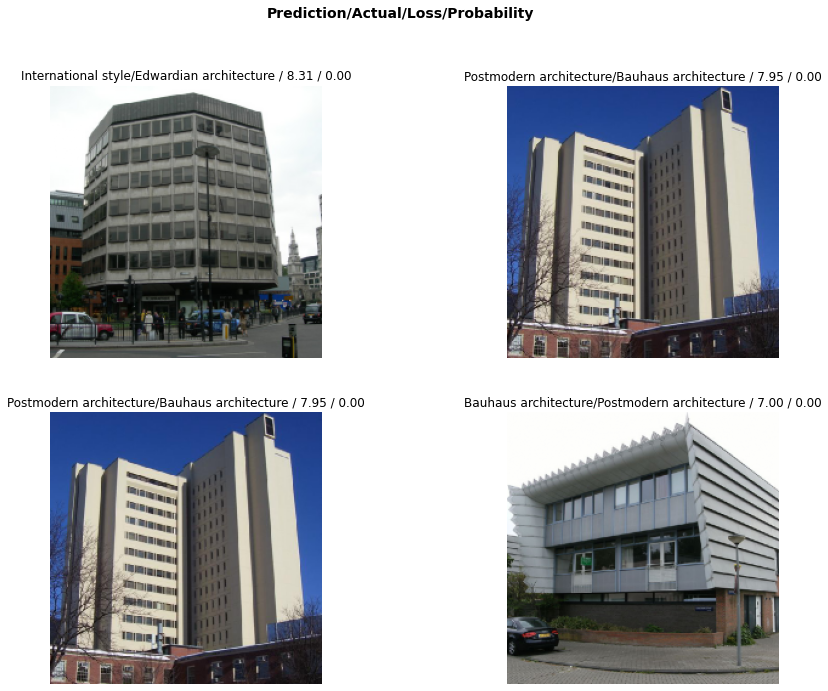

In [ ]:
interp.plot_top_losses(4, figsize=(15,11))

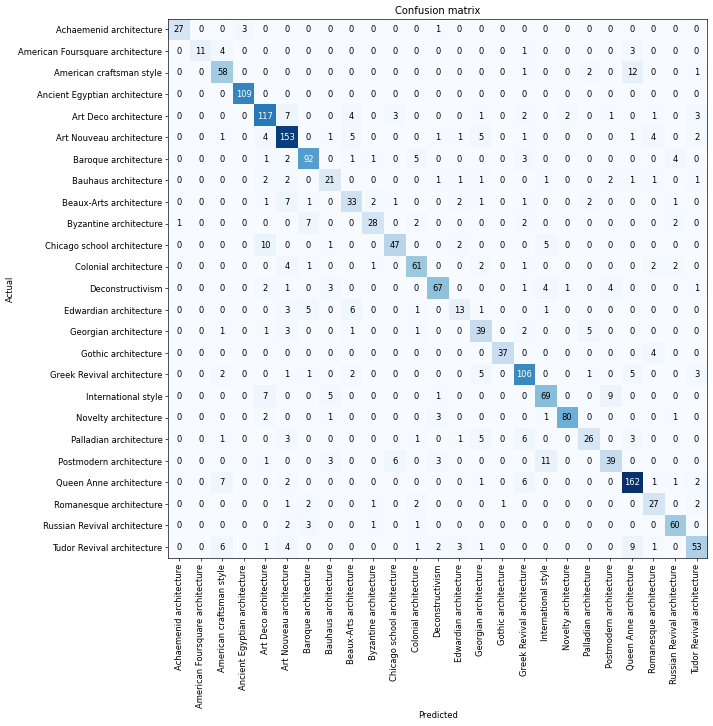

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will unfreeze our model and train some more.

Single number (1-e3): every layer same lr

Discriminative learning rates, lr for the early layers is smaller, so it will move around less, because we think they are already good. Good for transfer learning.

Discriminative learning rates:
*   Single number to slice slice(1-e3) final layers get that lr. The other layers get the that lr/3
*   In this case slice(1-e5,1-e3), the last layers will have 1-e3, the first layer will get 1-e5 and the rest layers equally spread number between this two



In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


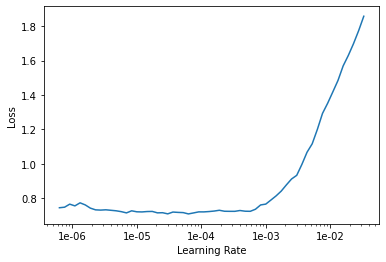

In [ ]:
learn.lr_find()
learn.recorder.plot_lr_find()

In [ ]:
learn.fit_one_cycle(4, lr_max=slice(1e-5,1e-4))

In [ ]:
learn.save('stage-2-resnet34')

## Training: resnet50

Now we will train in the same way as before but instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's use larger images too, since that way the network can see more detail.

### Training

In [17]:
# data = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2,
#         ds_tfms=tfms, size=299, num_workers=4, padding_mode='reflection', bs=64).normalize(imagenet_stats)
data = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2,
        item_tfms=Resize(299, method='squish'), # Ensure images are resized to the correct size before augmentation
        batch_tfms=[*tfms, Normalize.from_stats(*imagenet_stats)],
        size=299, num_workers=4, padding_mode='reflection', bs=64)

wd: weight decay
To avoid overfitting and still using a big amont of parameters. To make te function less complex, 

In [ ]:
# learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate], wd=1e-1).to_fp16()
# there is no impovement with fp16

In [ ]:
#Run this
learn = vision_learner(data, models.resnet50, metrics=[accuracy, error_rate], wd=1e-1)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to C:\Users\sengk/.cache\torch\hub\checkpoints\resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:04<00:00, 40.9MB/s] 


In [ ]:
# learn.fit_one_cycle(2)
learn.fit_one_cycle(6)

In [ ]:
learn.save('stage-1-resnet50-6cycles')

Path('architecture/models/stage-1-resnet50-2cycles.pth')

### Unfreezing, fine-tuning and learning rates

In [ ]:
learn.unfreeze()

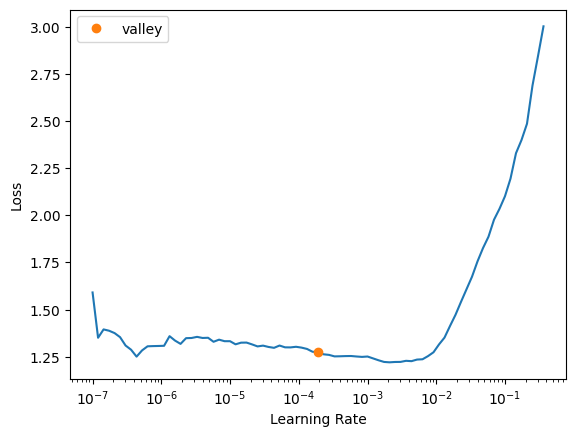

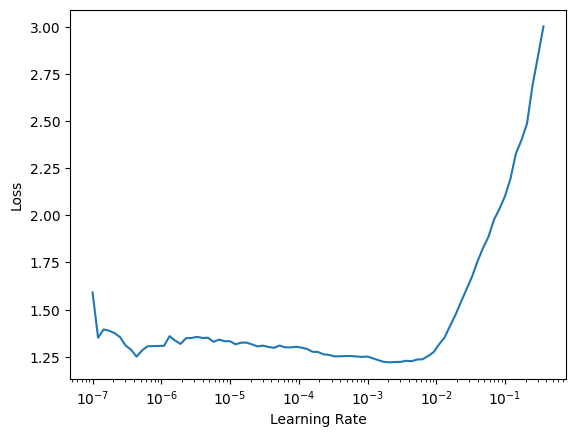

In [ ]:
learn.lr_find()
learn.recorder.plot_lr_find()

In [ ]:
learn.fit_one_cycle(6, lr_max=slice(1e-5,1e-4))

In [ ]:
learn.save('stage-2-resnet50')

Path('architecture/models/stage-2-resnet50.pth')

### Results resnet50

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=3)

[('International style', 'Postmodern architecture', np.int64(13)),
 ('Beaux-Arts architecture', 'Art Nouveau architecture', np.int64(11)),
 ('Art Deco architecture', 'Art Nouveau architecture', np.int64(10)),
 ('Postmodern architecture', 'International style', np.int64(10)),
 ('Tudor Revival architecture', 'Queen Anne architecture', np.int64(10)),
 ('Baroque architecture', 'Russian Revival architecture', np.int64(7)),
 ('International style', 'Art Deco architecture', np.int64(7)),
 ('Palladian architecture', 'Greek Revival architecture', np.int64(7)),
 ('American craftsman style', 'Greek Revival architecture', np.int64(6)),
 ('Art Deco architecture', 'Chicago school architecture', np.int64(6)),
 ('Chicago school architecture', 'Art Deco architecture', np.int64(6)),
 ('Edwardian architecture', 'Art Nouveau architecture', np.int64(6)),
 ('Beaux-Arts architecture', 'Chicago school architecture', np.int64(5)),
 ('Byzantine architecture', 'Romanesque architecture', np.int64(5)),
 ('Colonial

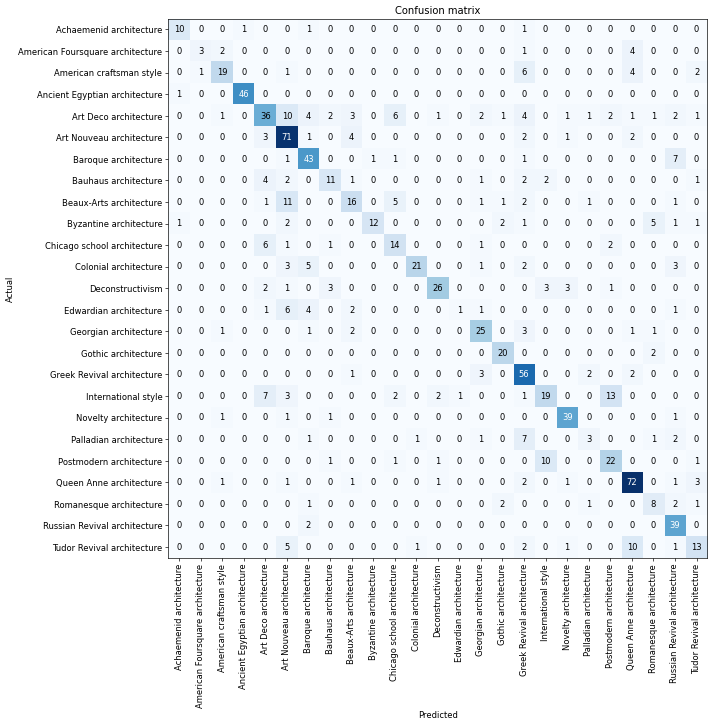

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Duplicate images on top losses, because of data augmentation

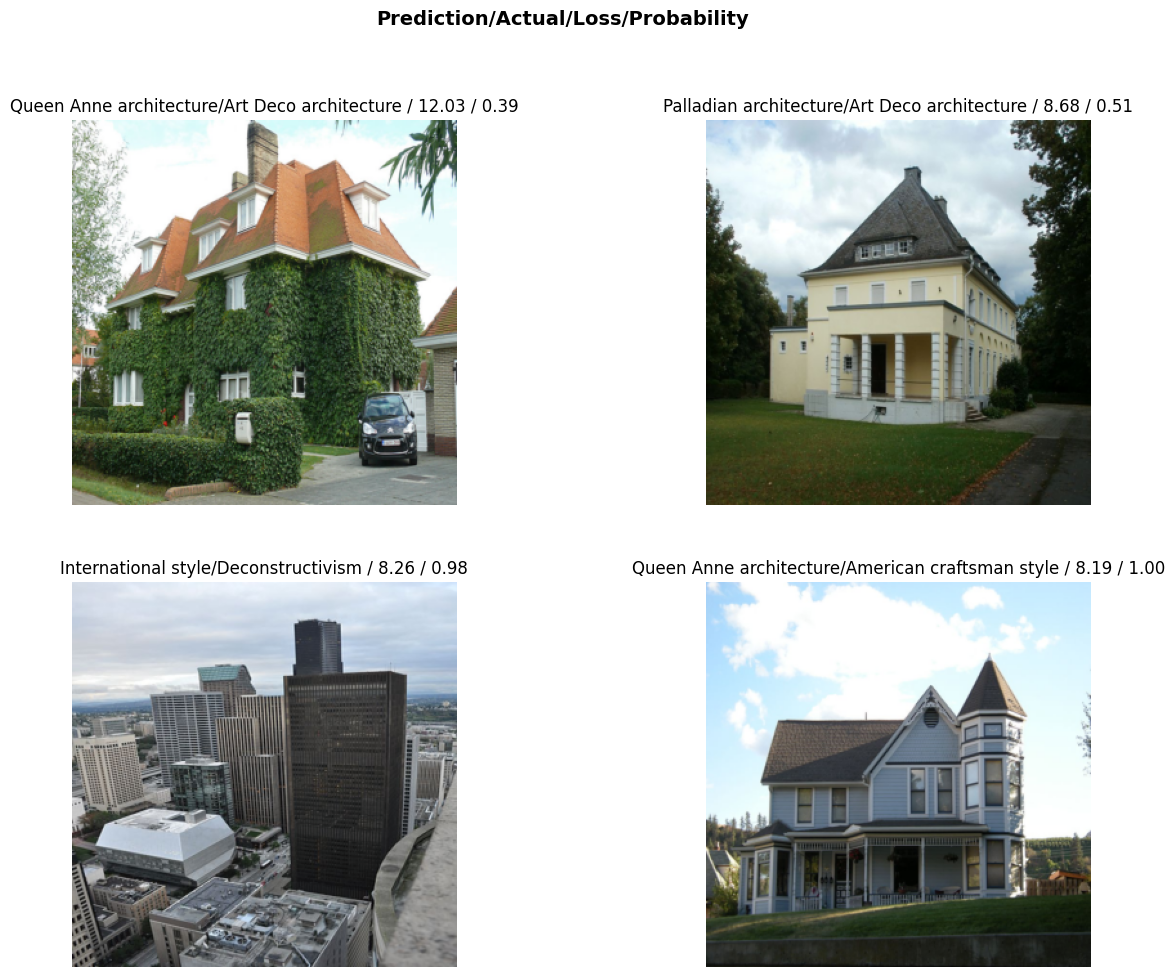

In [ ]:
interp.plot_top_losses(4, figsize=(15,11))

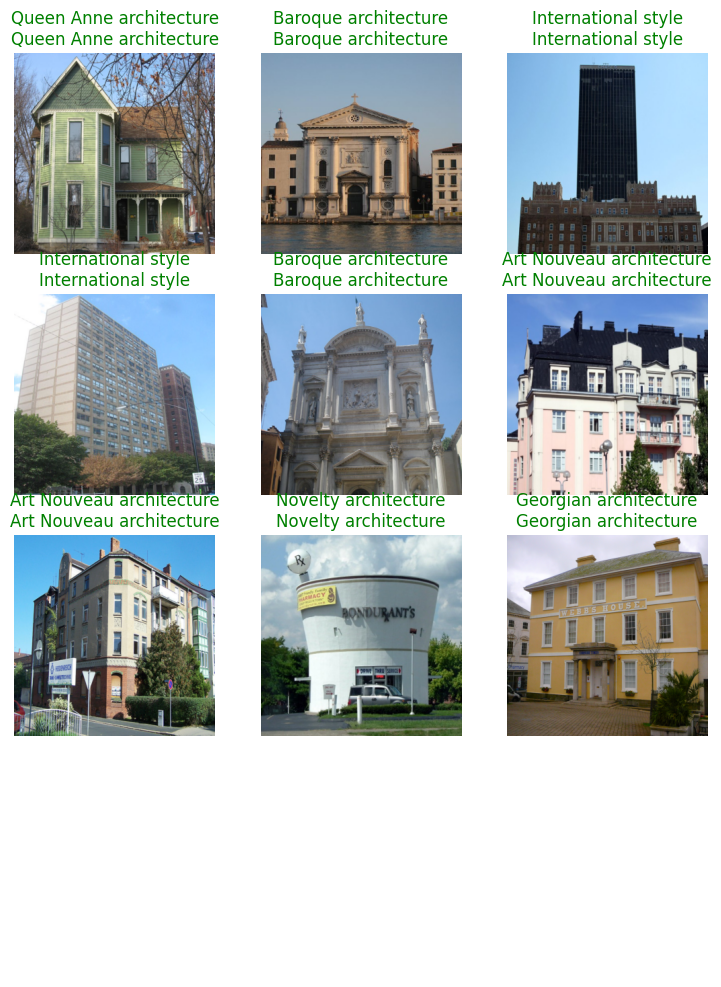

In [ ]:
learn.show_results(nrows=4)

In [ ]:
img = PILImage.create(path/'arcDataset'/'Bauhaus architecture'/'46_800px-Friedrichshafen_Hafenbahnhof_Zeppelinmuseum.jpg')

In [ ]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

'Art Deco architecture'

In [ ]:
outputs

tensor([8.2705e-04, 3.8901e-04, 5.3376e-04, 9.6638e-04, 6.6079e-01, 2.9942e-02,
        1.9105e-03, 2.5667e-01, 3.2918e-03, 1.5104e-04, 1.3700e-02, 9.1082e-05,
        1.5978e-02, 6.0663e-03, 3.4767e-04, 3.0565e-04, 1.2297e-03, 3.6544e-03,
        4.9296e-05, 4.5766e-04, 1.8095e-03, 2.8475e-05, 2.5163e-04, 4.9886e-04,
        6.0894e-05])

## Training: resnet101

Now we will train in the same way as before but instead of using resnet34, or resnet50 as our backbone we will use resnet101 (resnet34 is a 34 layer residual network, resnet50 has 50 layers, while resnet101 has 101 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet101 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's use larger images too, since that way the network can see more detail.

### Training

In [35]:
# data = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2,
#         ds_tfms=tfms, size=299, num_workers=4, padding_mode='reflection', bs=64).normalize(imagenet_stats)
data = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2,
        item_tfms=Resize(299, method='squish'), # Ensure images are resized to the correct size before augmentation
        batch_tfms=[*tfms, Normalize.from_stats(*imagenet_stats)],
        size=299, num_workers=4, padding_mode='reflection', bs=64)

wd: weight decay
To avoid overfitting and still using a big amont of parameters. To make te function less complex, 

In [ ]:
# learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate], wd=1e-1).to_fp16()
# there is no impovement with fp16

In [36]:
#Run this
learn = vision_learner(data, models.resnet101, metrics=[accuracy, error_rate], wd=1e-1)

In [ ]:
learn.fit_one_cycle(6)

In [ ]:
learn.save('stage-1-resnet101-6cycles')

### Unfreezing, fine-tuning and learning rates

In [39]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot_lr_find()

In [ ]:
learn.fit_one_cycle(6, lr_max=slice(1e-5,1e-4))

In [ ]:
learn.save('stage-2-resnet101')

### Results resnet101

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=3)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Duplicate images on top losses, because of data augmentation

In [ ]:
interp.plot_top_losses(4, figsize=(15,11))

In [ ]:
learn.show_results(nrows=4)

In [29]:
img = PILImage.create(path/'arcDataset'/'Bauhaus architecture'/'46_800px-Friedrichshafen_Hafenbahnhof_Zeppelinmuseum.jpg')

In [ ]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

In [ ]:
outputs

## Training: resnet152

Now we will train in the same way as before but instead of using resnet34, resnet50, or resnet101 as our backbone we will use resnet152 (resnet34 is a 34 layer residual network, resnet50 has 50 layers, resnet101 has 101 layers, while resnet152 has 152 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet152 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's use larger images too, since that way the network can see more detail.

### Training

In [10]:
# data = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2,
#         ds_tfms=tfms, size=299, num_workers=4, padding_mode='reflection', bs=64).normalize(imagenet_stats)
data = ImageDataLoaders.from_folder(path/'international-architectural-styles-combined', train=".", valid_pct=0.2,
        item_tfms=Resize(299, method='squish'), # Ensure images are resized to the correct size before augmentation
        batch_tfms=[*tfms, Normalize.from_stats(*imagenet_stats)],
        size=299, num_workers=4, padding_mode='reflection', bs=64)

wd: weight decay
To avoid overfitting and still using a big amont of parameters. To make te function less complex, 

In [14]:
# learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate], wd=1e-1).to_fp16()
# there is no impovement with fp16

In [11]:
#Run this
learn = vision_learner(data, models.resnet152, metrics=[accuracy, error_rate], wd=1e-1)

In [33]:
learn.fit_one_cycle(1)

KeyboardInterrupt: 

In [34]:
learn.save('stage-1-resnet152-6cycles')

Path('architecture/international-architectural-styles-combined/models/stage-1-resnet152-6cycles.pth')

### Unfreezing, fine-tuning and learning rates

In [35]:
learn.unfreeze()

c:\Users\sengk\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_loc

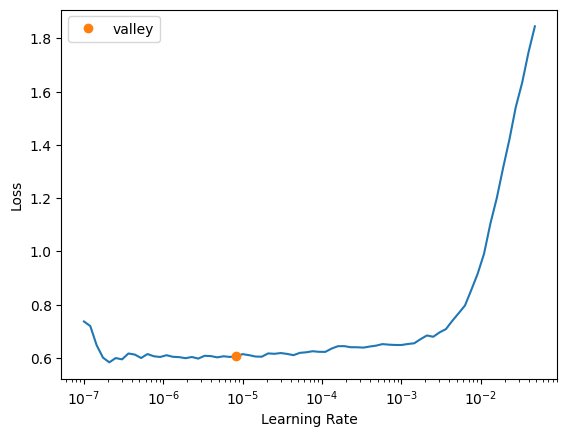

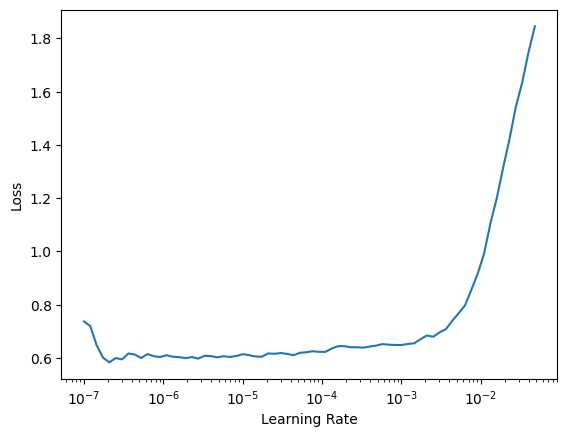

In [36]:
learn.lr_find()
learn.recorder.plot_lr_find()

In [37]:
learn.fit_one_cycle(6, lr_max=slice(1e-5,1e-4))

In [38]:
learn.save('stage-2-resnet152')

Path('architecture/international-architectural-styles-combined/models/stage-2-resnet152.pth')

### Results resnet152

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

In [16]:
interp.most_confused(min_val=3)

[('American craftsman style', 'Queen Anne architecture', np.int64(8)),
 ('American Foursquare architecture', 'Queen Anne architecture', np.int64(7)),
 ('Colonial architecture', 'Greek Revival architecture', np.int64(7)),
 ('International style', 'Bauhaus architecture', np.int64(7)),
 ('American craftsman style', 'American Foursquare architecture', np.int64(5)),
 ('Colonial architecture', 'Queen Anne architecture', np.int64(4)),
 ('International style', 'Postmodern architecture', np.int64(4)),
 ('Jain architecture', 'Dravidian architecture', np.int64(4)),
 ('American Foursquare architecture', 'American craftsman style', np.int64(3)),
 ('American Foursquare architecture',
  'Greek Revival architecture',
  np.int64(3)),
 ('Art Deco architecture', 'Art Nouveau architecture', np.int64(3)),
 ('Art Deco architecture', 'Stalinist architecture', np.int64(3)),
 ('Art Nouveau architecture', 'Stalinist architecture', np.int64(3)),
 ('Baroque architecture', 'Art Nouveau architecture', np.int64(3)),

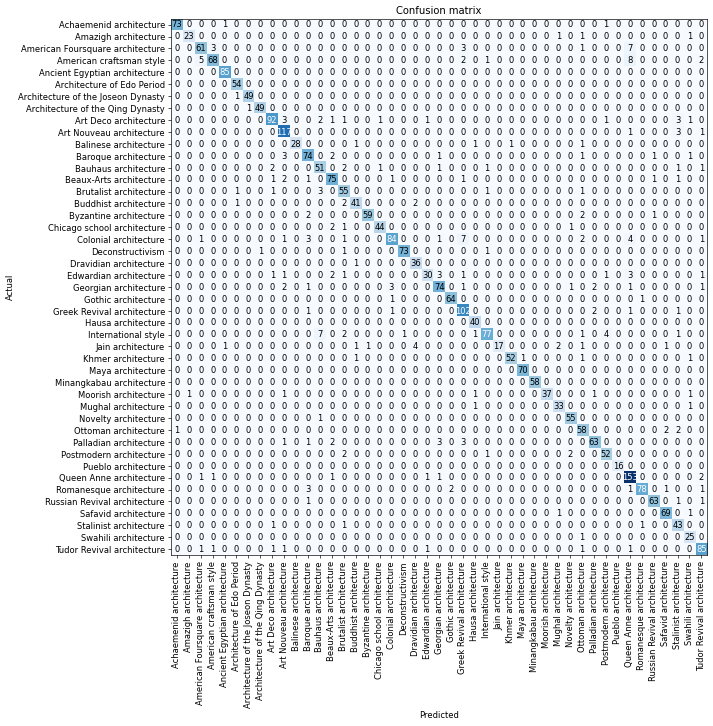

In [17]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Duplicate images on top losses, because of data augmentation

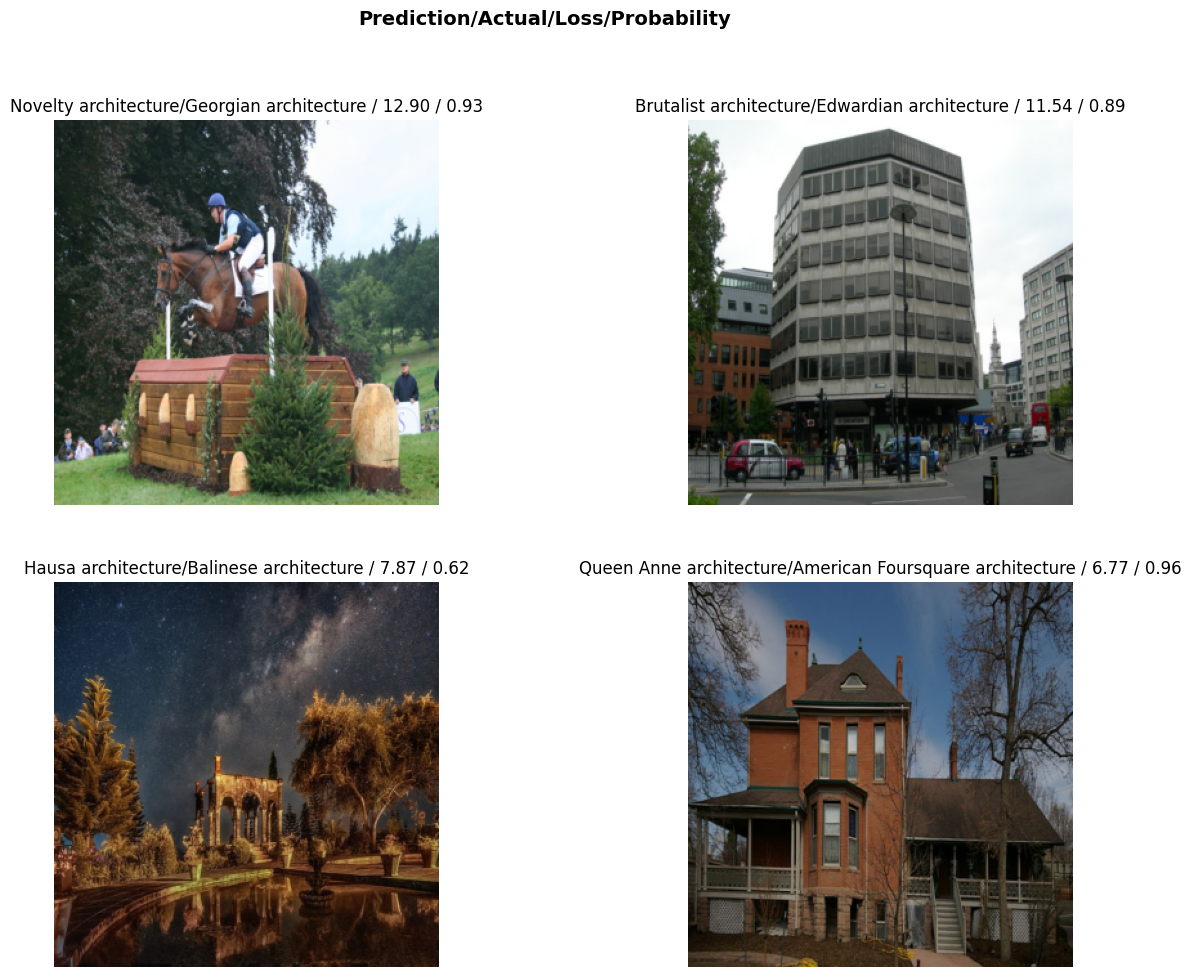

In [18]:
interp.plot_top_losses(4, figsize=(15,11))

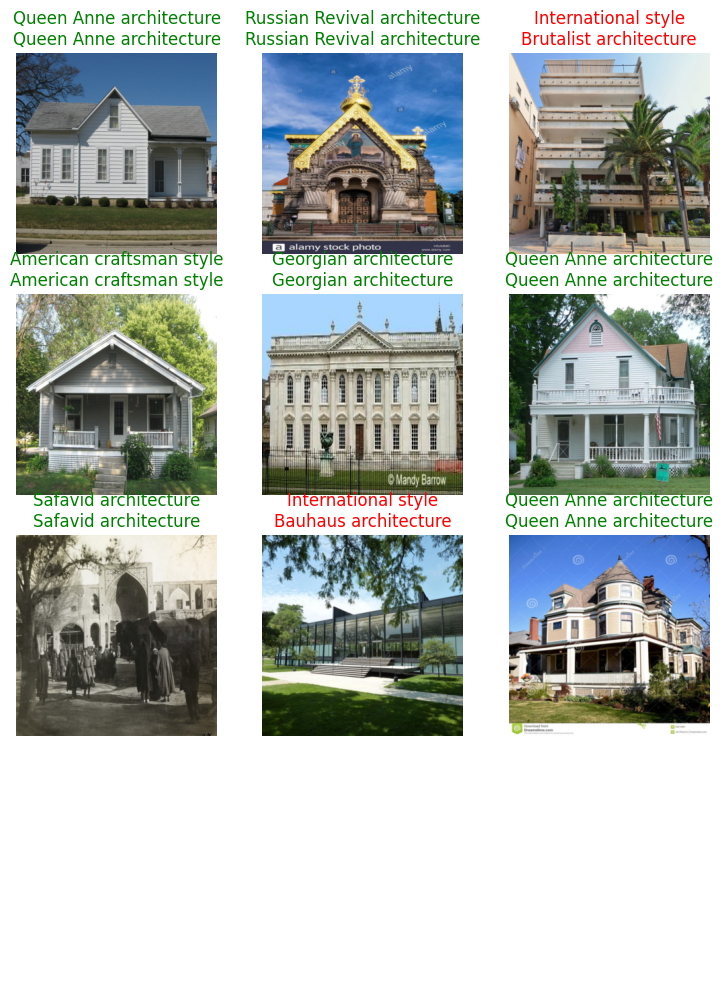

In [19]:
learn.show_results(nrows=4)

In [15]:
img = PILImage.create(path/'international-architectural-styles-combined'/'Khmer architecture'/'5.jpg')

In [16]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

'Khmer architecture'

In [17]:
outputs

tensor([3.3955e-03, 1.1964e-02, 9.0886e-04, 9.3827e-04, 5.0961e-04, 9.4639e-03,
        5.6896e-02, 4.5945e-02, 2.2185e-05, 4.1079e-05, 3.4919e-02, 2.0995e-06,
        8.5691e-05, 3.5454e-06, 6.1440e-04, 1.8749e-01, 5.8367e-05, 1.1494e-02,
        9.2255e-06, 1.6812e-03, 5.0698e-03, 6.0109e-05, 6.8401e-05, 3.0441e-04,
        1.4193e-04, 2.9210e-03, 8.0676e-04, 2.3694e-03, 4.3447e-01, 8.0651e-05,
        9.4016e-02, 8.9651e-04, 6.0363e-04, 3.5977e-03, 2.8248e-03, 3.5894e-05,
        2.2046e-04, 1.2332e-03, 5.6712e-05, 6.6098e-06, 4.7822e-05, 3.8278e-02,
        3.6071e-04, 4.4659e-02, 4.1994e-04])

## Putting model in production

### Download to deploy model

To put model in production, export the minimal state of your Learner.
This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

In [20]:
learn.export()

In [48]:
# Send the export.pkl file to the web app models directiory
! copy .\\architecture\\international-architectural-styles-combined\\export.pkl ..\\app\\models

        1 file(s) copied.


We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [23]:
img = PILImage.create(path/'international-architectural-styles-combined'/'Khmer architecture'/'5.jpg')

In [24]:
learn = load_learner(path/'international-architectural-styles-combined'/'export.pkl')

In [25]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'Khmer architecture'